In [1]:
pip install tensorflow

Defaulting to user installation because normal site-packages is not writeable
Note: you may need to restart the kernel to use updated packages.


In [2]:
import matplotlib.pyplot as plt
import tensorflow as tf
import numpy as np
import os
import pandas as pd
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.optimizers import Adam, RMSprop
from tensorflow.python.keras.models import Model
from tensorflow.python.keras.layers import Dense, Flatten, Dropout
#from tensorflow.keras.applications.resnet import ResNet50

In [3]:
from keras.applications.vgg16 import VGG16

In [4]:
#from tensorflow.keras.mixed_precision import experimental as mixed_precision
policy = mixed_precision.Policy('mixed_float16')
mixed_precision.set_policy(policy)
print('Compute dtype: %s' % policy.compute_dtype)
print('Variable dtype: %s' % policy.variable_dtype)

NameError: name 'mixed_precision' is not defined

In [5]:
train_dir = "F:/sc/chest_xray/train"
validation_dir = "F:/sc/chest_xray/val"
#test_dir = "C:/Users/DELL/Desktop/Brain/Data/small/test"
test_dir = "F:/sc/chest_xray/test"


In [6]:
model1 = VGG16(include_top=False,input_shape=(224, 224, 3), weights='imagenet')

In [7]:
input_shape = (224,224)

In [8]:
datagen_train = ImageDataGenerator(rescale=1./255,
                                  width_shift_range=0.1,
                                  height_shift_range=0.1,
                                  horizontal_flip=True,
                                  vertical_flip=False)


datagen_test = ImageDataGenerator(rescale=1./255)


batch_size = 8
generator_train = datagen_train.flow_from_directory(directory=train_dir,
                                                    target_size=input_shape,
                                                    batch_size=batch_size,
                                                    shuffle=True)

generator_test = datagen_test.flow_from_directory(directory=test_dir,
                                                  target_size=input_shape,
                                                  batch_size=batch_size,
                                                  shuffle=False)


Found 4686 images belonging to 2 classes.
Found 586 images belonging to 2 classes.


In [9]:
def print_layer_trainable():
    for layer in model1.layers:
        print("{0}:\t{1}".format(layer.trainable, layer.name))


print_layer_trainable()

True:	input_1
True:	block1_conv1
True:	block1_conv2
True:	block1_pool
True:	block2_conv1
True:	block2_conv2
True:	block2_pool
True:	block3_conv1
True:	block3_conv2
True:	block3_conv3
True:	block3_pool
True:	block4_conv1
True:	block4_conv2
True:	block4_conv3
True:	block4_pool
True:	block5_conv1
True:	block5_conv2
True:	block5_conv3
True:	block5_pool


In [10]:
transfer_layer = model1.get_layer('block5_pool')
conv_model = Model(inputs=model1.input, outputs=transfer_layer.output)

In [11]:
from tensorflow.keras.models import Sequential
#for layer in conv_model.layers:
#    layer.trainable = False
    
# Start a new Keras Sequential model.
new_model = Sequential()

# Add the convolutional part of the VGG16 model from above.
#new_model.add(Sequential(tf.keras.layers.Dense(3))) 
new_model.add(conv_model)

# Flatten the output of the VGG16 model because it is from a
# convolutional layer.
new_model.add(Flatten())

# Add a dense (aka. fully-connected) layer.
# This is for combining features that the VGG16 model has
# recognized in the image.

new_model.add(Dense(1024, activation='relu'))
new_model.add(Dropout(0.5))
new_model.add(Dense(512, activation='relu'))
# Add a dropout-layer which may prevent overfitting and
# improve generalization ability to unseen data e.g. the test-set.
#new_model.add(Dense(512, activation='relu'))


# Add the final layer for the actual classification.
new_model.add(Dense(2, activation='softmax'))

In [12]:
optimizer = Adam(learning_rate=1e-5)
loss = 'binary_crossentropy'
metrics = ['categorical_accuracy']
#name="binary_crossentropy"
#metrics=[tf.keras.metrics.BinaryAccuracy(),
new_model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=1e-5),
              loss=tf.keras.losses.BinaryCrossentropy(), metrics=metrics)

In [14]:
from keras.callbacks import Callback
weights = {0:3.37, 1:1}
epochs = 15

# from keras.callbacks import ModelCheckpoint
# filepath = r'/content/drive/MyDrive/Colab Notebooks/Shawon/New folder (5)/resnet-ep{epoch:03d}-loss{loss:.3f}-val_loss{val_loss:.3f}.h5'

# checkpoint = ModelCheckpoint(filepath, monitor='val_accuracy', verbose=1, save_best_only=True, save_weights_only = True, mode='max', )

steps_per_epoch = generator_train.n / batch_size
steps_test = generator_test.n / batch_size

#steps_per_epoch = 20
#steps_test = 100
history = new_model.fit_generator(generator=generator_train,
                                  epochs=epochs,
                                  steps_per_epoch=steps_per_epoch,
                                  validation_data=generator_test,
                                  validation_steps=steps_test,class_weight = weights,
                                  # callbacks = [checkpoint],
                                  )

C:\Users\Lenovo\AppData\Local\Temp\ipykernel_11916\819415514.py:15: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  history = new_model.fit_generator(generator=generator_train,


Epoch 1/15
585/585 [==============================] - 3925s 7s/step - loss: 0.0642 - categorical_accuracy: 0.9838 - val_loss: 0.7544 - val_categorical_accuracy: 0.8464
Epoch 2/15
585/585 [==============================] - 4094s 7s/step - loss: 0.0673 - categorical_accuracy: 0.9831 - val_loss: 0.4527 - val_categorical_accuracy: 0.8976
Epoch 3/15
585/585 [==============================] - 4032s 7s/step - loss: 0.0365 - categorical_accuracy: 0.9898 - val_loss: 0.9046 - val_categorical_accuracy: 0.8601
Epoch 4/15
585/585 [==============================] - 4237s 7s/step - loss: 0.0508 - categorical_accuracy: 0.9876 - val_loss: 0.8538 - val_categorical_accuracy: 0.8737
Epoch 5/15
585/585 [==============================] - 24326s 42s/step - loss: 0.0519 - categorical_accuracy: 0.9893 - val_loss: 0.5190 - val_categorical_accuracy: 0.9147
Epoch 6/15
585/585 [==============================] - 3938s 7s/step - loss: 0.0471 - categorical_accuracy: 0.9874 - val_loss: 0.5291 - val_categorical_accurac

In [15]:
new_model.save_weights('F:/sc/chest_xray/vgg16withcs.h5')

In [13]:
new_model1 = new_model.load_weights('F:/sc/chest_xray/vgg16withcs.h5')

ValueError: Unable to load weights saved in HDF5 format into a subclassed Model which has not created its variables yet. Call the Model first, then load the weights.

In [17]:
finaltestCNV_dir = "F:/sc/chest_xray/val"
datagen_finaltestCNV_dir = ImageDataGenerator(rescale=1./255)

generator_finaltestCNV_dir = datagen_finaltestCNV_dir.flow_from_directory(directory=finaltestCNV_dir,
                                                  target_size=input_shape,
                                                  batch_size=batch_size,
                                                  shuffle=False)
steps_finaltestCNV_dir = generator_finaltestCNV_dir.n / batch_size
y_pred = new_model.predict_generator(generator_finaltestCNV_dir,steps = steps_finaltestCNV_dir)

Found 584 images belonging to 2 classes.


C:\Users\Lenovo\AppData\Local\Temp\ipykernel_11916\2023091792.py:9: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  y_pred = new_model.predict_generator(generator_finaltestCNV_dir,steps = steps_finaltestCNV_dir)


In [18]:
predicted_class_indices=np.argmax(y_pred,axis=1)
print(predicted_class_indices)

[0 1 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 

In [19]:
#print(predicted_class_indices[0:585])

In [20]:
unique, frequency = np.unique(predicted_class_indices, 
                              return_counts = True)
# print unique values array
print("Unique Values:", 
      unique)
  
# print frequency array
print("Frequency Values:",
      frequency)

Unique Values: [0 1]
Frequency Values: [295 289]


In [21]:
#print(predicted_class_indices[:9])

In [22]:
#print(predicted_class_indices[9:292])

In [21]:
y_true = [0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,
          0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,
          0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,
          0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,
          0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,
          0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,
          
          1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,
          1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,
          1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,
          1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,
          1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,
          1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1
              
         ]

In [22]:
from sklearn.metrics import confusion_matrix
array = confusion_matrix(y_true, predicted_class_indices)

In [23]:
#array=[[15,1],[4,5]]

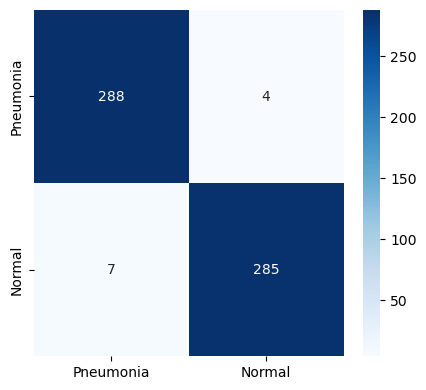

In [24]:
import seaborn as sn
import pandas as pd
import matplotlib.pyplot as plt
df_cm = pd.DataFrame(array, index = ["Pneumonia", "Normal"],
                  columns = ["Pneumonia", "Normal"])
plt.figure(figsize = (5,4.5))
sn.heatmap(df_cm, annot=True, cmap='Blues', fmt='g')
plt.savefig('F:/sc/chest_xray/confusion.pdf')  

In [25]:
pip install lime

Defaulting to user installation because normal site-packages is not writeable
Note: you may need to restart the kernel to use updated packages.


In [26]:
import lime
from lime import lime_image
from PIL import Image
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
from skimage.segmentation import mark_boundaries

def xAI(model,img_dir):
    image = Image.open(img_dir)
    imgx = np.asarray(image)
    #print(imgx[:,:,0].shape)
    imgx = image.resize((224, 224))
    img = np.asarray(imgx)
    img = img/255
    img2 = np.zeros( ( np.array(img).shape[0], np.array(img).shape[1], 3 ) )
    img2[:,:,0] = img # same value in each channel
    img2[:,:,1] = img
    img2[:,:,2] = img
    #print(img2.shape)
    explainer = lime_image.LimeImageExplainer(random_state=42)
    explanation = explainer.explain_instance(img2, new_model.predict, labels=["Normal", "Pneumonia"],top_labels=2, hide_color=0,num_samples=1000)
    #plt.imshow(img)
    image, mask = explanation.get_image_and_mask(
             model.predict(img2.reshape((1,224,224,3))).argmax(axis=1)[0],
        
             positive_only=False,
        #num_features=10,
             hide_rest=False)
    plt.axis ('off')
    plt.imshow(mark_boundaries(image, mask))
    plt.savefig('F:/sc/chest_xray/lime124true.png')
    plt.savefig('F:/sc/chest_xray/lime124true.pdf')

  0%|          | 0/1000 [00:00<?, ?it/s]

1/1 [==============================] - 0s 313ms/step


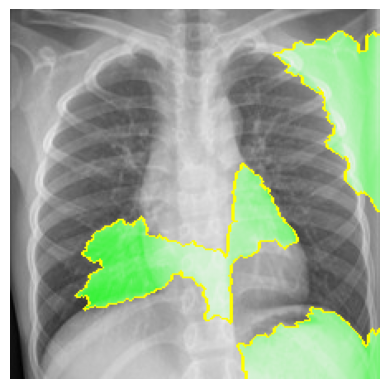

In [27]:
#0-0
xAI(new_model, "F:/sc/chest_xray/val/NORMAL/IM-0006-0001.jpeg")

  0%|          | 0/1000 [00:00<?, ?it/s]

1/1 [==============================] - 0s 319ms/step


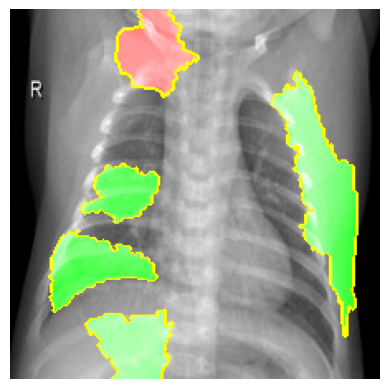

In [28]:
#0-0
xAI(new_model, "F:/sc/chest_xray/val/NORMAL/IM-0083-0001.jpeg")

In [29]:
IMG_SIZE = (299, 299)
def transform_image(image_path, size):
    '''
    Function to transform an image to normalized numpy array
    '''
    img = image.load_img(image_path, target_size=size)
    img = image.img_to_array(img)# Transforming the image to get the shape as [channel, height, width]
    img = np.expand_dims(img, axis=0) # Adding dimension to convert array into a batch of size (1,299,299,3)
    img = img/255.0 # normalizing the image to keep within the range of 0.0 to 1.0
    
    return img

normalized_img = transform_image(image_path, IMG_SIZE)

NameError: name 'image_path' is not defined

  0%|          | 0/1000 [00:00<?, ?it/s]

1/1 [==============================] - 0s 302ms/step


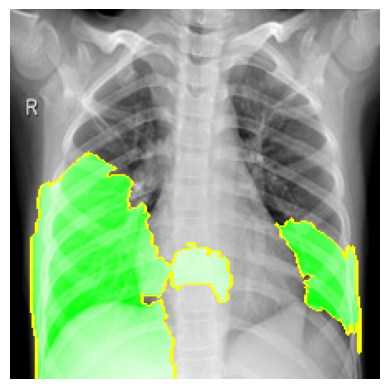

In [30]:
#actual-0
#predict-1
xAI(new_model, "F:/sc/chest_xray/val/NORMAL/IM-0180-0001.jpeg")

  0%|          | 0/1000 [00:00<?, ?it/s]

1/1 [==============================] - 0s 302ms/step


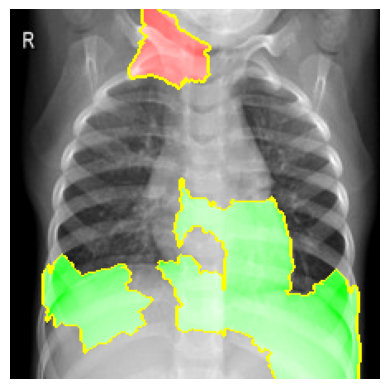

In [31]:
#actual-0
#predict-1
xAI(new_model, "F:/sc/chest_xray/val/NORMAL/IM-0189-0001.jpeg")

  0%|          | 0/1000 [00:00<?, ?it/s]

1/1 [==============================] - 0s 328ms/step


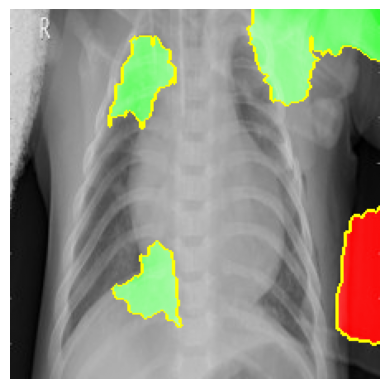

In [32]:
#actual-1
#predict-0
xAI(new_model, "F:/sc/chest_xray/val/PNEUMONIA/person299_bacteria_1414.jpeg")

  0%|          | 0/1000 [00:00<?, ?it/s]

1/1 [==============================] - 0s 298ms/step


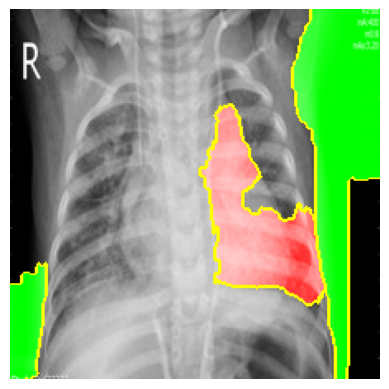

In [33]:
#actual-1
#predict-0
xAI(new_model, "F:/sc/chest_xray/val/PNEUMONIA/person1310_bacteria_3302.jpeg")

  0%|          | 0/1000 [00:00<?, ?it/s]

1/1 [==============================] - 0s 303ms/step


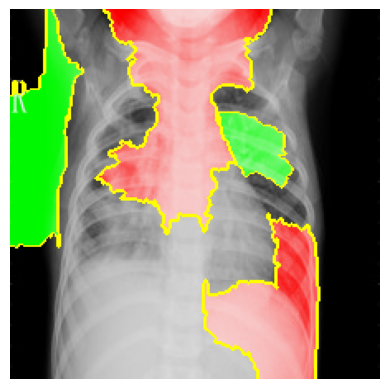

In [34]:
#actual-1
#predict-1
xAI(new_model, "F:/sc/chest_xray/val/PNEUMONIA/person1954_bacteria_4886.jpeg")

  0%|          | 0/1000 [00:00<?, ?it/s]

1/1 [==============================] - 0s 301ms/step


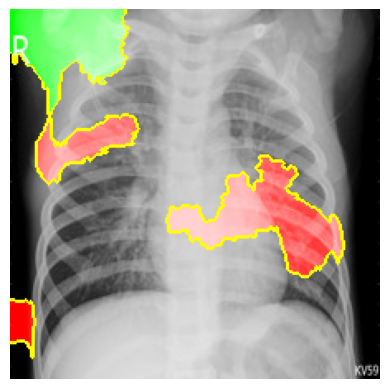

In [35]:
#actual-1
#predict-1
xAI(new_model, "F:/sc/chest_xray/val/PNEUMONIA/person1396_virus_2399.jpeg")

  0%|          | 0/1000 [00:00<?, ?it/s]

1/1 [==============================] - 0s 302ms/step


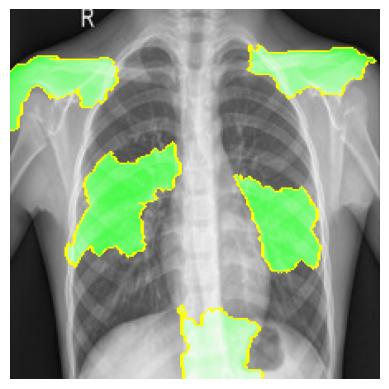

In [36]:
#0-0
xAI(new_model, "F:/sc/chest_xray/test/NORMAL/IM-0001-0001.jpeg")

  0%|          | 0/1000 [00:00<?, ?it/s]

1/1 [==============================] - 0s 308ms/step


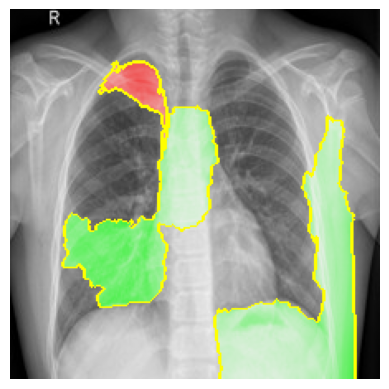

In [37]:
#0-0
xAI(new_model, "F:/sc/chest_xray/test/NORMAL/IM-0027-0001.jpeg")

  0%|          | 0/1000 [00:00<?, ?it/s]

1/1 [==============================] - 0s 322ms/step


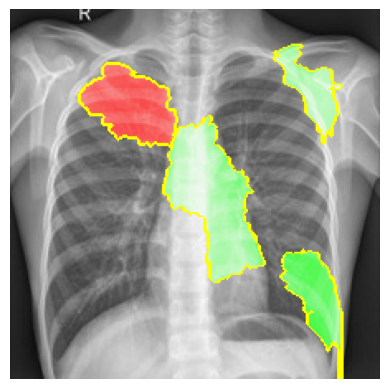

In [38]:
#actual-0
#predict-1
xAI(new_model, "F:/sc/chest_xray/test/Normal/IM-0007-0001.jpeg")

  0%|          | 0/1000 [00:00<?, ?it/s]

1/1 [==============================] - 0s 333ms/step


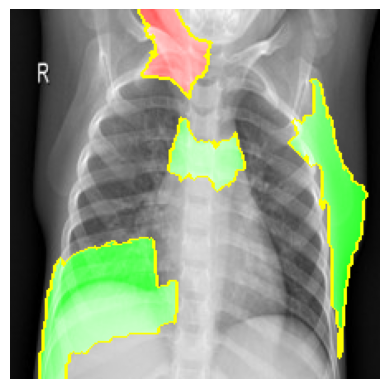

In [39]:
#actual-0
#predict-1
xAI(new_model, "F:/sc/chest_xray/test/Normal/IM-0069-0001.jpeg")

  0%|          | 0/1000 [00:00<?, ?it/s]

1/1 [==============================] - 0s 365ms/step


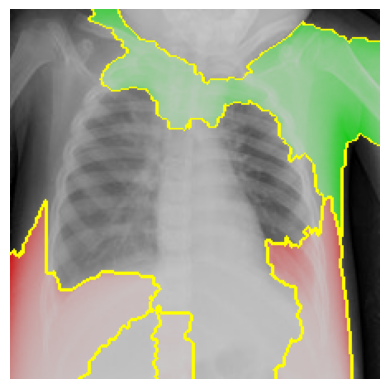

In [40]:
#actual-1
#predict-1
xAI(new_model, "F:/sc/chest_xray/test/Pneumonia/person1682_virus_2899.jpeg")

  0%|          | 0/1000 [00:00<?, ?it/s]

1/1 [==============================] - 0s 306ms/step


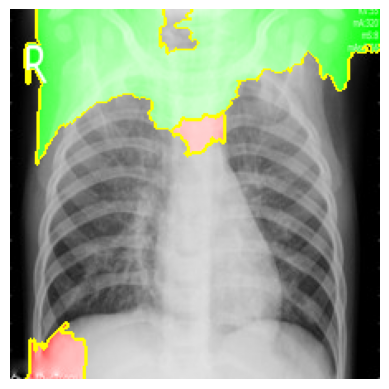

In [41]:
#actual-1
#predict-1CORRect
xAI(new_model, "F:/sc/chest_xray/test/Pneumonia/person1673_virus_2889.jpeg")

In [42]:
from PIL import Image
# Open the image form working directory
image = Image.open('F:/sc/chest_xray/test/PNEUMONIA/person34_virus_76.jpeg')
image = image.resize((224, 224))
# summarize some details about the image
print(image.format)
print(image.size)
print(image.mode)

data = np.asarray(image)

data = data/255

data2 = np.zeros( ( np.array(data).shape[0], np.array(data).shape[1], 3 ) )
data2[:,:,0] = data # same value in each channel
data2[:,:,1] = data
data2[:,:,2] = data
print(data2.shape)
y = new_model.predict(data2.reshape(1,224,224,3))

predicted_class_indices=np.argmax(y,axis=1)
print(predicted_class_indices)

None
(224, 224)
L
(224, 224, 3)
1/1 [==============================] - 0s 154ms/step
[1]


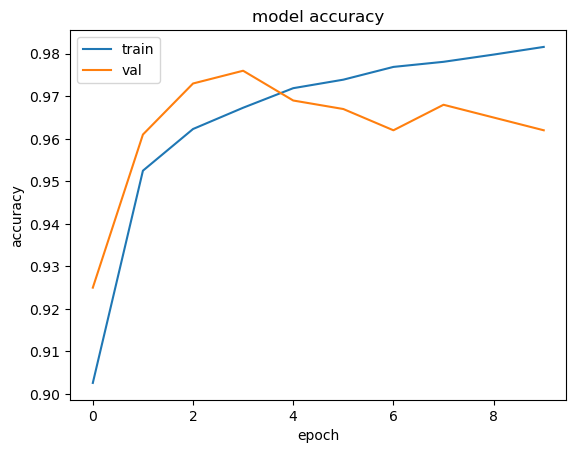

In [43]:
import matplotlib.pyplot as plt
plt.plot([0.9026,0.9525,0.9623,0.9673,0.9719,0.9739,0.9769,0.9781,0.9798,0.9816])
plt.plot([0.9250,0.9610,0.9730,0.9760,0.9690,0.9670,0.9620,0.9680,0.9650,0.9620])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

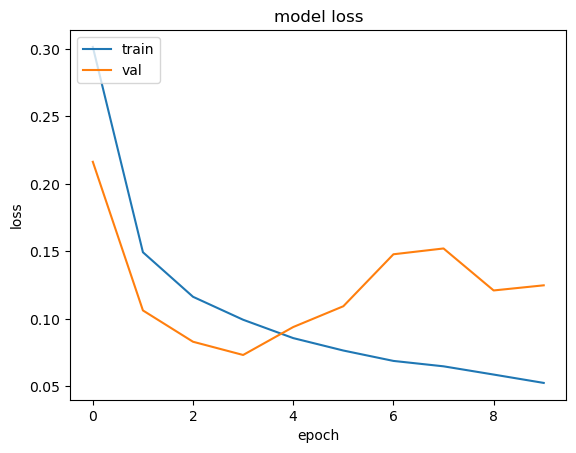

In [44]:
plt.plot([0.3015,0.1494,0.1164,0.0994,0.0858,0.0766,0.0689,0.0649,0.0588,0.0526])
plt.plot([0.2164,0.1063,0.0831,0.0733,0.0940,0.1094,0.1479,0.1522,0.1211,0.1249])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train','val'], loc='upper left')
plt.show()

In [45]:
loss: 0.6435 - categorical_accuracy: 0.6578 - val_loss: 4.3284 - val_categorical_accuracy: 0.5000
loss: 0.3592 - categorical_accuracy: 0.8439 - val_loss: 4.7390 - val_categorical_accuracy: 0.5000
loss: 0.3245 - categorical_accuracy: 0.8740 - val_loss: 1.9577 - val_categorical_accuracy: 0.5433
loss: 0.3080 - categorical_accuracy: 0.8802 - val_loss: 1.1540 - val_categorical_accuracy: 0.6400
loss: 0.2663 - categorical_accuracy: 0.8961 - val_loss: 0.6151 - val_categorical_accuracy: 0.8000
loss: 0.2520 - categorical_accuracy: 0.8977 - val_loss: 0.2536 - val_categorical_accuracy: 0.9067
loss: 0.2271 - categorical_accuracy: 0.9157 - val_loss: 0.2361 - val_categorical_accuracy: 0.9000
loss: 0.2131 - categorical_accuracy: 0.9245 - val_loss: 0.1594 - val_categorical_accuracy: 0.9300
loss: 0.1933 - categorical_accuracy: 0.9245 - val_loss: 0.1425 - val_categorical_accuracy: 0.9500
loss: 0.2106 - categorical_accuracy: 0.9257 - val_loss: 0.1735 - val_categorical_accuracy: 0.9267
loss: 0.1738 - categorical_accuracy: 0.9320 - val_loss: 0.1375 - val_categorical_accuracy: 0.9433
loss: 0.1721 - categorical_accuracy: 0.9378 - val_loss: 0.1329 - val_categorical_accuracy: 0.9533
loss: 0.1692 - categorical_accuracy: 0.9395 - val_loss: 0.1305 - val_categorical_accuracy: 0.9500
loss: 0.1360 - categorical_accuracy: 0.9528 - val_loss: 0.1414 - val_categorical_accuracy: 0.9467
loss: 0.1312 - categorical_accuracy: 0.9578 - val_loss: 0.1156 - val_categorical_accuracy: 0.9567
loss: 0.1544 - categorical_accuracy: 0.9462 - val_loss: 0.1109 - val_categorical_accuracy: 0.9533
loss: 0.1440 - categorical_accuracy: 0.9520 - val_loss: 0.1138 - val_categorical_accuracy: 0.9567
loss: 0.1257 - categorical_accuracy: 0.9595 - val_loss: 0.1102 - val_categorical_accuracy: 0.9567
loss: 0.1233 - categorical_accuracy: 0.9574 - val_loss: 0.0947 - val_categorical_accuracy: 0.9633
loss: 0.1101 - categorical_accuracy: 0.9620 - val_loss: 0.0968 - val_categorical_accuracy: 0.9633
loss: 0.1130 - categorical_accuracy: 0.9595 - val_loss: 0.0929 - val_categorical_accuracy: 0.9633
loss: 0.1194 - categorical_accuracy: 0.9583 - val_loss: 0.1030 - val_categorical_accuracy: 0.9533
loss: 0.0946 - categorical_accuracy: 0.9679 - val_loss: 0.0954 - val_categorical_accuracy: 0.9567
loss: 0.0888 - categorical_accuracy: 0.9708 - val_loss: 0.0853 - val_categorical_accuracy: 0.9633
loss: 0.0861 - categorical_accuracy: 0.9737 - val_loss: 0.0768 - val_categorical_accuracy: 0.9733
loss: 0.0933 - categorical_accuracy: 0.9708 - val_loss: 0.0928 - val_categorical_accuracy: 0.9667
loss: 0.0877 - categorical_accuracy: 0.9670 - val_loss: 0.0843 - val_categorical_accuracy: 0.9667
loss: 0.0805 - categorical_accuracy: 0.9708 - val_loss: 0.0717 - val_categorical_accuracy: 0.9733
loss: 0.0704 - categorical_accuracy: 0.9762 - val_loss: 0.0762 - val_categorical_accuracy: 0.9767
loss: 0.0861 - categorical_accuracy: 0.9712 - val_loss: 0.0718 - val_categorical_accuracy: 0.9700
loss: 0.0716 - categorical_accuracy: 0.9741 - val_loss: 0.0655 - val_categorical_accuracy: 0.9700

SyntaxError: invalid syntax (4062200539.py, line 1)